# Analyzing the Error in Numerical Discretization of the Frenet Frame

In [1]:
# ruff: noqa: E402

%load_ext autoreload
%autoreload 2

# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl
import dotenv


ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
sys.path.append(str(ROOT))

## Load the Network


In [2]:
import geopandas as gpd
from src.geometry import RoadNetwork


mainline_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=["EBL1", "WBL1"],
    step_size=0.01,
)

full_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=None,
    step_size=0.01
)

LANE_WIDTH = 3.55
LANE_NUM = 2

## Read in the Trajectories


In [3]:
from datetime import timedelta
import polars as pl
from src.radar import CalibratedRadar
from src.pipelines.open_file import prep_df


sample_fraction = 0.2


radar_obj = CalibratedRadar(
    radar_location_path=ROOT / "configuration" / "march_calibrated.yaml",
)


radar_df = (
    pl.scan_parquet(
        Path(os.environ.get("RAW_DATA_DIR")).joinpath("*.parquet"),
    )
    .with_columns(
        pl.col("epoch_time").dt.replace_time_zone("UTC"),
    )
    .filter(pl.col("epoch_time").dt.month() == 3)
    .collect()
    .sample(fraction=sample_fraction, seed=42)
    .lazy()
    .pipe(prep_df, f=radar_obj)
    .pipe(
        mainline_net.map_to_lane,
        dist_upper_bound=LANE_WIDTH * LANE_NUM
        - (LANE_WIDTH / 2)
        + 0.5,  # centered on one of the lanes,
        utm_x_col="utm_x",
        utm_y_col="utm_y",
    )
    .filter(pl.col("name").is_not_null())
    .rename({"name": "lane"})
)

function: create_object_id took: 0.00029015541076660156 seconds
function: filter_short_trajectories took: 0.0004298686981201172 seconds
function: clip_trajectory_end took: 0.0002071857452392578 seconds
function: resample took: 0.0002281665802001953 seconds
function: fix_duplicate_positions took: 0.00013971328735351562 seconds
function: set_timezone took: 5.0067901611328125e-05 seconds
function: add_cst_timezone took: 3.409385681152344e-05 seconds
function: add_heading took: 3.075599670410156e-05 seconds
function: rotate_radars took: 0.00048613548278808594 seconds
function: update_origin took: 0.0004885196685791016 seconds


## Find the Round Trip Error

In [4]:
error_df = mainline_net.frenet2xy(
    radar_df.drop(['x_lane', 'y_lane']).rename({'utm_x': 'x', 'utm_y': 'y'}),
    lane_col='lane',
    s_col='s',
    d_col='d',
).with_columns(
    (pl.col('x') - pl.col('x_lane')).alias('dx'),
    (pl.col('y') - pl.col('y_lane')).alias('dy'),
).with_columns(
    (pl.col('dx') ** 2 + pl.col('dy') ** 2).sqrt().alias('dist_error'),
).filter(
    (pl.col('s') > 1) & (pl.col('s') < (pl.col('s').max() - 10))
)

In [5]:
error_df['dist_error'].describe()

statistic,value
str,f64
"""count""",3.857551e6
"""null_count""",0.0
"""mean""",0.002499
"""std""",0.001446
"""min""",6.9849e-10
"""25%""",0.001246
"""50%""",0.002497
"""75%""",0.00375
"""max""",0.007396


<Axes: xlabel='d', ylabel='dy'>

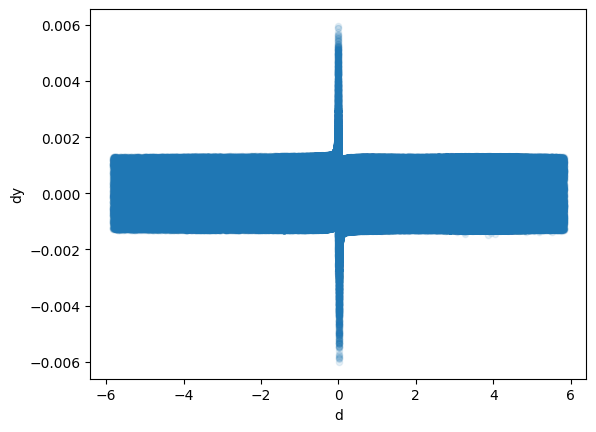

In [6]:
error_df.filter(
    pl.col('lane').str.contains('EBL1')
)[['d', 'dy']].to_pandas().plot.scatter('d', 'dy', alpha=0.1)